Import 

In [6]:
%pip install scikit-learn xgboost shap

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load

In [9]:
import sys
import os

# Add the parent directory to sys.path so scripts.utils can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

try:
	from scripts.utils import add_claim_flags
except ModuleNotFoundError:
	# Dummy function if scripts.utils is not available
	def add_claim_flags(df):
		# Add a dummy 'HasClaim' column if not present
		if 'HasClaim' not in df.columns:
			df['HasClaim'] = df['TotalClaims'] > 0
		return df

df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|', engine='python', on_bad_lines='skip')
df = add_claim_flags(df)
df['VehicleAge'] = 2025 - df['RegistrationYear']
df_model = df[['TotalClaims', 'CalculatedPremiumPerTerm', 'VehicleAge', 'Gender', 'Province', 'HasClaim']]
df_model = df_model.dropna()

Prediction Model

In [12]:
df_claims = df_model[df_model['HasClaim']]
X = pd.get_dummies(df_claims[['VehicleAge', 'Gender', 'Province']], drop_first=True)
y = df_claims['TotalClaims']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    results[name] = {"model": model, "rmse": rmse, "r2": r2}
    print(f"{name} -> RMSE: {rmse:.2f}, R2: {r2:.2f}")


LinearRegression -> RMSE: 38365.78, R2: 0.02
RandomForest -> RMSE: 38942.68, R2: -0.01
XGBoost -> RMSE: 39230.00, R2: -0.03


SHAP Interpretation for Best Model

PermutationExplainer explainer: 556it [02:30,  3.59it/s]                         


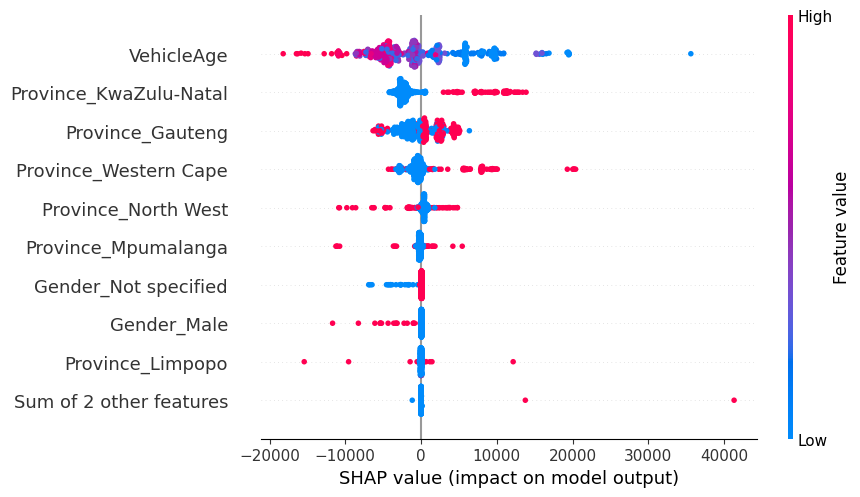

In [14]:
# Choose best model (example: Random Forest)
best_model = results["RandomForest"]["model"]

# Convert boolean columns to int for SHAP compatibility
X_test_numeric = X_test.copy()
for col in X_test_numeric.select_dtypes(include='bool').columns:
	X_test_numeric[col] = X_test_numeric[col].astype(int)

# Explain predictions using SHAP
explainer = shap.Explainer(best_model.predict, X_test_numeric)
shap_values = explainer(X_test_numeric)

# Visualize feature importance
shap.plots.beeswarm(shap_values)
